In [288]:
##### POC Bundesbank API

### Data Preparation

# Fetching set of selected key as .json

#curl -X 'GET' \
#  'https://api.statistiken.bundesbank.de/rest/data/BBXE1/M.A1.CY.BBLI.GLIP00.IND.I00?detail=full' \
#  -H 'accept: application/vnd.sdmx.data+json;version=1.0.0'

# transforming into dicts
# Transforming the dicts to PDs
# Merging the Time series together as one matrix
# Extracting different frequencies

### Exploratory Analytics

### Descriptive Worx

### Analytix

### Predictive Analytix

### Prescriptive Advise

In [380]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [366]:
headers = {
    'accept': 'application/vnd.sdmx.data+json;version=1.0.0',
}

params = {
    'detail': 'full',
}

rezpo = requests.get(
    'https://api.statistiken.bundesbank.de/rest/data/BBFB1/Q.N.DE.I8.S1.S1.T.B.CA._Z._Z._Z._T._X.N',
    params=params,
    headers=headers,
)

# https://api.statistiken.bundesbank.de/rest/data/BBXE1/M.A1.CY.BBLI.GLIP00.IND.I00 OK WORKS!

response_list = rezpo.json()

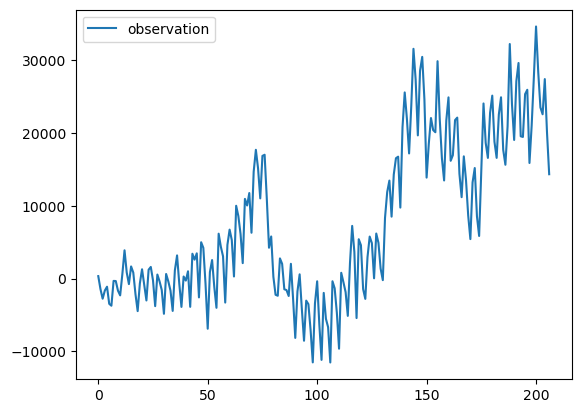

        time  observation
0    1971-Q1      343.141
1    1971-Q2    -1433.400
2    1971-Q3    -2758.713
3    1971-Q4    -1643.307
4    1972-Q1    -1110.165
..       ...          ...
202  2021-Q3    23506.225
203  2021-Q4    22569.247
204  2022-Q1    27404.642
205  2022-Q2    20116.985
206  2022-Q3    14338.526

[207 rows x 2 columns]


In [372]:
### Data-Points:
# data -> dataSets -> series -> 0:0:0:0:0:0:0 -> observations -> all
# Extract Numbers from respose
#Number_Dict = response_list["data"]["dataSets"][0]["series"]['0:0:0:0:0:0:0']["observations"]


##### Initiate Number Array
Number_Array = []

Number_Dict = response_list["data"]["dataSets"][0]["series"]["0:0:0:0:0:0:0:0:0:0:0:0:0:0:0"]["observations"]

for key in Number_Dict:
    Number_Array.append(Number_Dict[key][0])
    
# Convert into pd DF for further use
df_n = pd.DataFrame(Number_Array, columns = ["observation"])

# Number_Dict = response_list["data"]["dataSets"][0]["series"]["0:0:0:0:0:0:0:0:0:0:0:0:0:0:0"]["observations"][element][0]

### Initiate Number Array
# Number_Array = []

# for element in Number_Dict:
#    Number_Array.append(value)
    
# Convert into pd DF for further use
#df_n = pd.DataFrame(Number_Array, columns = ["observation"])
#print(df_n)

###### Time Stamps:
# data -> structure -> dimensions -> observation -> values

# Extract timestamp from Response
Timestamp_Dict = response_list["data"]["structure"]["dimensions"]["observation"][0]["values"]

# Initiate List
Timestamp_Array = []

# Loop through Timestamps and put them inside the array

for element in Timestamp_Dict:
    Timestamp_Array.append(element["id"])

# Convert into pd DF for further use

df_t = pd.DataFrame(Timestamp_Array, columns = ["time"])

### Merge and Plot

df_merged = pd.concat([df_t,df_n],axis=1)
df_merged.plot()
plt.show()

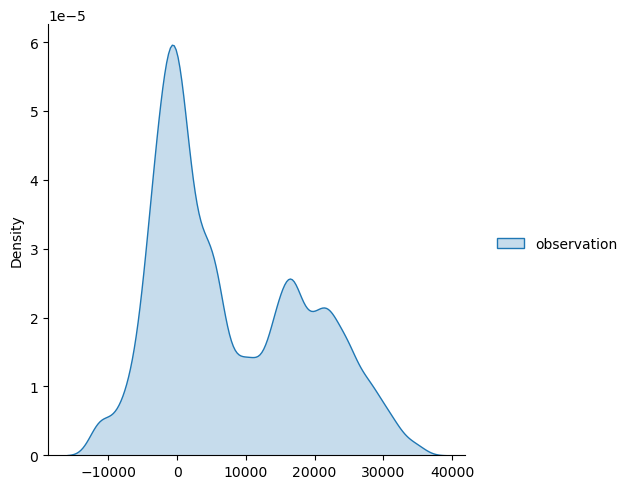

In [395]:
sns.displot(data=df_merged,kind="kde",bw_adjust=.4, fill = "true")